In [1]:
%load_ext lab_black
%cd ..

/home/shim/cev/dl/log-analytics


In [2]:
import argparse
import math
import multiprocessing
import sys
from datetime import datetime
from pathlib import Path
from pprint import pformat

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer
import yaml
from easydict import EasyDict
from pytorch_transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
)
from sklearn.model_selection import StratifiedKFold
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AlbertForSequenceClassification,
    AlbertTokenizer,
    DebertaForSequenceClassification,
    DebertaTokenizer,
    SqueezeBertTokenizer,
    SqueezeBertForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification,
)

from datasets import load_test_data, load_train_data, MyDataset
from utils import SAM, AverageMeter, CustomLogger, FocalLoss, seed_everything

from main import MyTrainer
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
with open("config/squeezebert-uncased.yaml", "r") as f:
    C = EasyDict(yaml.load(f, yaml.FullLoader))
    C.result_dir = Path(C.result_dir)
    C.dataset.dir = Path(C.dataset.dir)
    seed_everything(C.seed, deterministic=False)

In [4]:
C

{'model': {'name': 'squeezebert/squeezebert-uncased'},
 'comment': None,
 'result_dir': PosixPath('results/squeezebert-uncased'),
 'debug': False,
 'seed': 20210425,
 'train': {'SAM': False,
  'folds': [2],
  'checkpoints': [None],
  'loss': {'name': 'focal', 'gamma': 2},
  'optimizer': {'name': 'AdamW'},
  'finetune': {'do': True, 'step1_epochs': 3, 'step2_epochs': 5},
  'max_epochs': 10,
  'lr': 1e-05,
  'scheduler': {'name': 'ReduceLROnPlateau',
   'params': {'factor': 0.5, 'patience': 3, 'verbose': True}}},
 'dataset': {'dir': PosixPath('data/ori'), 'batch_size': 20, 'num_workers': 8}}

In [5]:
trainer = MyTrainer(C, 1, "results/squeezebert-uncased/squeezebert-uncased-focal-AdamW-lr1e-05_2.pth")

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing SqueezeBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SqueezeBertForSequenceClassification were no

Load pretrained results/squeezebert-uncased/squeezebert-uncased-focal-AdamW-lr1e-05_2.pth


In [6]:
model = trainer.model
model.eval()
torch.set_grad_enabled(False)

In [7]:
model

SqueezeBertForSequenceClassification(
  (transformer): SqueezeBertModel(
    (embeddings): SqueezeBertEmbeddings(
      (word_embeddings): Embedding(30528, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): SqueezeBertEncoder(
      (layers): ModuleList(
        (0): SqueezeBertModule(
          (attention): SqueezeBertSelfAttention(
            (query): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (key): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (value): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=-1)
            (matmul_qk): MatMulWrapper()
            (matmul_qkv): MatMulWrapper()
          )
          (post_attention): ConvDr

In [8]:
activation = []


def hook(model, input, output):
    activation.append(output.detach().cpu())

In [9]:
# model.transformer.encoder.layers[11].output.conv1d.register_forward_hook(conv1_hook)
model.transformer.pooler.dense.register_forward_hook(hook)

In [10]:
vds = trainer.vdl.dataset

In [11]:
id, text, tlevel, otext = vds[0]

In [12]:
otext

'kibana: {"type":"log","tags":["warning","monitoring-ui","kibana-monitoring"],"message":"Error: No Living connections\\n at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:226:15)\\n at next (/usr/share/kibana/node_modules/elasticsearch/src/lib/connection_pool.js:214:7)\\n at process._tickCallback (internal/process/next_tick.js:61:11)"}'

In [13]:
model(text[None].cuda())

SequenceClassifierOutput(loss=None, logits=tensor([[ 5.0254, -1.9911, -5.8643, -0.6411, -6.6716, -1.8612, -7.7830]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [14]:
activation[0].shape

torch.Size([1, 768])

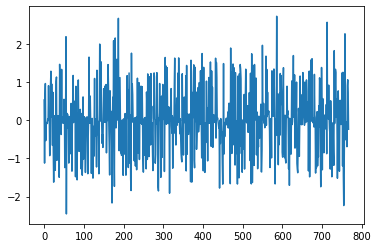

In [17]:
plt.plot(activation[0][0])

In [19]:
activation = []
tlevels = []
otexts = []

for i in range(100):
    id, text, tlevel, otext = vds[i]
    tlevels.append(tlevel)
    otexts.append(otext)
    model(text[None].cuda())

In [23]:
tlevels = torch.stack(tlevels)

In [26]:
tlevels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1])

In [28]:
activation = torch.cat(activation)

In [29]:
activation.shape

torch.Size([100, 768])

In [39]:
feats = activation

In [30]:
feat0 = activation[tlevels == 0]
feat1 = activation[tlevels == 1]

In [32]:
feat0.shape

torch.Size([65, 768])

## Level7을 넣었을 때

In [33]:
df = pd.read_csv("data/ori/validation_sample.csv")

In [34]:
df

,full_log
0,type=ANOM_PROMISCUOUS msg=audit(1600402733.466...
1,"oscap: msg: ""xccdf-result"", scan-id: ""00016007..."
2,Sep 22 10:56:19 localhost kernel: Out of memor...


In [36]:
id, text, otext = trainer.dl_test2.dataset[0]

In [37]:
otext

'type=ANOM_PROMISCUOUS msg=audit(1600402733.466:4503): dev=enp2s0 prom=256 old_prom=0 auid=4294967295 uid=0 gid=0 ses=4294967295 type=SYSCALL msg=audit(1600402733.466:4503): arch=c000003e syscall=54 success=yes exit=0 a0=c a1=107 a2=1 a3=7f856aed1140 items=0 ppid=1 pid=12152 auid=4294967295 uid=0 gid=0 euid=0 suid=0 fsuid=0 egid=0 sgid=0 fsgid=0 tty=(none) ses=4294967295 comm="W#01-enp2s0" exe="/usr/sbin/suricata" subj=system_u:system_r:unconfined_service_t:s0 key=(null) type=PROCTITLE msg=audit(1600402733.4'

In [40]:
activation = []

In [41]:
model(text[None].cuda())

SequenceClassifierOutput(loss=None, logits=tensor([[-1.6924,  4.6911, -3.3423, -1.9573, -3.6974, -1.4233, -4.2919]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [47]:
feat = activation[0][0]

In [51]:
feats.shape, feat.shape

(torch.Size([100, 768]), torch.Size([768]))

In [54]:
dist = torch.norm(feats - feat[None], dim=1, p=None)
dist

tensor([25.8751, 27.5754, 25.6763, 25.6763, 27.3760, 25.6763, 25.8751, 25.8751,
        27.5163,  1.2990, 26.6238, 25.6763, 26.3050, 25.6763, 27.5369,  1.5110,
        25.6763, 26.8754, 27.5386, 27.6015, 25.6763,  2.2112,  2.0290, 27.5192,
         5.7089,  1.7554,  1.2794, 25.9356, 25.6763, 25.7994,  1.3693, 25.6763,
        25.6763, 25.6763, 26.9179, 25.6763, 26.6691, 26.8754, 26.6178,  1.9773,
        26.0493,  1.2987, 25.6763,  2.0514,  2.0265,  1.5182, 26.9307, 26.6121,
        25.6763,  1.4115, 27.4454,  2.1961,  1.4076,  1.7181,  1.3593,  1.4109,
        25.6763, 26.8763, 25.6763,  1.5942, 27.3684, 27.4871, 26.8764, 26.6522,
        27.5486, 26.8660,  2.1594,  1.2969, 25.6763, 25.6763, 25.6763, 25.6763,
        25.6763, 25.6763, 26.1618,  1.8016, 26.8618,  1.9518,  1.6773, 25.8751,
         1.6214, 25.6763,  1.7576, 26.0694,  1.6784,  1.1638, 27.5159, 27.4623,
        26.5709,  1.3030, 25.6763,  1.6463,  1.3763, 25.6763, 25.6763, 27.4264,
        25.6763, 25.6763,  4.6733,  1.45

In [65]:
knn = dist.topk(50, largest=False)

In [66]:
values, indices = knn

In [67]:
values

tensor([ 1.1638,  1.2794,  1.2969,  1.2987,  1.2990,  1.3030,  1.3593,  1.3693,
         1.3763,  1.4076,  1.4109,  1.4115,  1.4591,  1.5110,  1.5182,  1.5942,
         1.6214,  1.6463,  1.6773,  1.6784,  1.7181,  1.7554,  1.7576,  1.8016,
         1.9518,  1.9773,  2.0265,  2.0290,  2.0514,  2.1594,  2.1961,  2.2112,
         4.6733,  5.7089, 25.6763, 25.6763, 25.6763, 25.6763, 25.6763, 25.6763,
        25.6763, 25.6763, 25.6763, 25.6763, 25.6763, 25.6763, 25.6763, 25.6763,
        25.6763, 25.6763])

In [68]:
tlevels[indices]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

1과 유사하다고 한다.

## Level7 - 2

In [82]:
id, text, otext = trainer.dl_test2.dataset[1]

In [83]:
activation = []
model(text[None].cuda())

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.2355, -1.4136, -1.8940,  3.5928, -1.8239, -0.6595, -2.1214]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [84]:
feat = activation[0][0]
feats.shape, feat.shape

(torch.Size([100, 768]), torch.Size([768]))

In [85]:
dist = torch.norm(feats - feat[None], dim=1, p=None)
knn = dist.topk(50, largest=False)
values, indices = knn
values

tensor([10.7915, 23.1768, 23.5835, 23.7057, 23.8905, 23.8905, 23.8905, 23.8905,
        23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905,
        23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905,
        23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905, 23.8905,
        24.0862, 24.1018, 24.3701, 24.3833, 24.3833, 24.3833, 24.3833, 24.5180,
        24.5637, 24.5952, 24.5952, 25.2794, 25.2806, 25.3417, 25.3424, 25.3521,
        25.3568, 25.3607])

In [86]:
tlevels[indices]

tensor([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

## Level7 - 3

In [87]:
id, text, otext = trainer.dl_test2.dataset[2]

In [88]:
activation = []
model(text[None].cuda())

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.3105, -0.1176, -6.3091, -1.1940, -7.1354, -1.5113, -8.1841]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [89]:
feat = activation[0][0]
feats.shape, feat.shape

(torch.Size([100, 768]), torch.Size([768]))

In [90]:
dist = torch.norm(feats - feat[None], dim=1, p=None)
knn = dist.topk(50, largest=False)
values, indices = knn
values

tensor([7.6338, 7.8809, 7.9859, 8.0167, 8.0278, 8.0326, 8.0354, 8.0464, 8.0518,
        8.0572, 8.0638, 8.1615, 8.3131, 8.3131, 8.5420, 8.5784, 8.9566, 8.9566,
        8.9566, 8.9566, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214,
        9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214,
        9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214, 9.0214,
        9.0214, 9.0214, 9.0214, 9.1332, 9.1336])

In [91]:
tlevels[indices]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

## Level1을 넣었을 때

In [72]:
id, text, tlevel, otext = vds[201]

In [73]:
otext

'sudo: pam_unix(sudo:session): session opened for user root by (uid=0)'

In [74]:
activation = []
model(text[None].cuda())

SequenceClassifierOutput(loss=None, logits=tensor([[-2.0477,  4.7689, -3.2803, -1.4810, -3.4924, -1.2048, -4.0213]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [75]:
feat = activation[0][0]

In [77]:
dist = torch.norm(feats - feat[None], dim=1, p=None)
dist

tensor([26.4535, 28.1218, 26.2340, 26.2340, 27.9592, 26.2340, 26.4535, 26.4535,
        28.0624,  4.8755, 27.2916, 26.2340, 26.7065, 26.2340, 28.0698,  4.9054,
        26.2340, 27.4782, 28.0605, 28.1424, 26.2340,  4.5989,  4.3468, 28.0799,
         2.8076,  5.0091,  4.8156, 26.4084, 26.2340, 26.4078,  4.7500, 26.2340,
        26.2340, 26.2340, 27.4833, 26.2340, 27.2904, 27.4782, 27.2829,  4.4628,
        26.6671,  4.8775, 26.2340,  4.6481,  4.8592,  4.7229, 27.4916, 27.2732,
        26.2340,  4.6519, 28.0334,  4.5210,  4.6802,  4.4863,  4.6994,  4.4391,
        26.2340, 27.4487, 26.2340,  4.7494, 27.9735, 28.0175, 27.4495, 27.2616,
        28.0867, 27.4380,  4.6664,  4.8254, 26.2340, 26.2340, 26.2340, 26.2340,
        26.2340, 26.2340, 26.7560,  4.6748, 27.4366,  4.6317,  5.0064, 26.4535,
         4.8921, 26.2340,  4.7555, 26.5884,  4.6077,  4.5663, 28.0412, 28.0269,
        25.5936,  4.7897, 26.2340,  4.7246,  4.7942, 26.2340, 26.2340, 27.9863,
        26.2340, 26.2340,  0.0000,  4.82

In [78]:
knn = dist.topk(50, largest=False)

In [79]:
values, indices = knn

In [80]:
values

tensor([ 0.0000,  2.8076,  4.3468,  4.4391,  4.4628,  4.4863,  4.5210,  4.5663,
         4.5989,  4.6077,  4.6317,  4.6481,  4.6519,  4.6664,  4.6748,  4.6802,
         4.6994,  4.7229,  4.7246,  4.7494,  4.7500,  4.7555,  4.7897,  4.7942,
         4.8156,  4.8254,  4.8282,  4.8592,  4.8755,  4.8775,  4.8921,  4.9054,
         5.0064,  5.0091, 25.5936, 26.2340, 26.2340, 26.2340, 26.2340, 26.2340,
        26.2340, 26.2340, 26.2340, 26.2340, 26.2340, 26.2340, 26.2340, 26.2340,
        26.2340, 26.2340])

In [81]:
tlevels[indices]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])